In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import least_squares
import math

# 1. Defining Functions

## Single First Order Reaction

In [117]:
T_ref = 27
gas_const = scipy.constants.gas_constant
# [[A]_0, k(T_ref), E_a]
single_params = np.array([97.9, (7.4 * 10**(-5)) ,115.83]) # purity of nr ce-sds

def single_rate_constant(T, kT_ref, E_a):
    e = math.e**(((-E_a)/gas_const)*((1/T) - (1/T_ref)))
    return (kT_ref * e)

def A_single (params, t,T):
    k = single_rate_constant(T, params[1], params[2])
    e = math.e**((-1)* k *t)
    return (params[0] * e)

def B_single(params, t, T, B_0):
    A = A_single(params, t, T)
    return (B_0 + params[0] - A)

## Parallel First Order Reaction

In [3]:
# [[A]0, [B]0, kB(Tref), kC(Tref), Ea,B, Ea,C]
parallel_params = [1,2,3,4,5,6]

def parallel_rate_constant(T, kT_refX, E_aX):
    e = math.e**(((-E_aX)/gas_const)*((1/T) - (1/T_ref)))
    return (kT_refX * e)

def A_parallel(params, t, T):
    k_b = parallel_rate_constant(T, params[2], params[4])
    k_c = parallel_rate_constant(T, params[3], params[5])
    e = math.e**((-1)*( k_b + k_c )*t)
    return (params[0] * e)

"""
For B and C, we are taking the assumption given in the article that: 

[B] = [A]_0\frac{k_b}{k_b + k_c} ...

where k_b and k_c would be txhe rate czonstant of the reference temperature
"""
def B_parallel(params, t, T):
    k_b = parallel_rate_constant(T, params[2], params[4])
    k_c = parallel_rate_constant(T, params[3], params[5])
    e = math.e**((-1)*(k_b + k_c) * t)
    total_k = params[2] + params[3]
    x = params[0] * (params[2] / total_k) * (1 - e)
    return (x - params[1])
    
def C_parallel(params, t, T):
    k_b = parallel_rate_constant(T, params[2], params[4])
    k_c = parallel_rate_constant(T, params[3], params[5])
    e = math.e**((-1)*(k_b + k_c) * t)
    total_k = params[2] + params[3]
    x = params[0] * (params[3] / total_k) * (1 - e)
    # [C]_0 = 100 - ([A]_0 + [B]_0
    return (x - (100 - (params[0] + params[1])))

## Single N-th Order Reaction

In [119]:
# [[A]_0, k(T_ref), E_a, N]
single_n_params = np.array([99.6, (5.63 * 10**(-4)) ,120, 0])

def A_n_single(params, t, T):
    k = single_rate_constant(T, params[1], params[2])
    A = (params[0] ** (1 - params[3])) - k * t * (1-params[3])
    return (A ** (1/(1-params[3])))
            
def B_n_single(params, t, T):
    A = A_n_single(params, t, T)
    return (100 - A)

# 2. Test with Data (AI-Generated Data)

In [59]:
df = pd.read_csv('sample.csv')
df['[B]'] = df['[B] HMW'] + df['[C] LMW']

t0_df = df[df['Time (months)'] == 0]
t1_df = df[(df['Time (months)'] == 1) & (df['Temp (K)'].isin([278.15, 298.15, 313.15]))]
t3_df = df[(df['Time (months)'] == 3) & (df['Temp (K)'].isin([278.15, 298.15, 313.15]))]
t6_df = df[(df['Time (months)'] == 6) & (df['Temp (K)'].isin([278.15, 298.15]))]

df_train = pd.concat([t0_df, t1_df, t3_df, t6_df], ignore_index=True)
df_train

,Time (months),Temp (°C),Temp (K),[A] Monomer (single),[A] Monomer (parallel),[B] HMW,[C] LMW,[B]
0,0,5,278.15,99.100000,99.100000,0.000000,0.000000,0.000000
1,0,25,298.15,99.100000,99.100000,0.000000,0.000000,0.000000
2,0,40,313.15,99.100000,99.100000,0.000000,0.000000,0.000000
3,1,5,278.15,99.099142,99.099142,0.000240,0.000619,0.000858
4,1,25,298.15,99.081539,99.081539,0.006074,0.012386,0.018461
5,1,40,313.15,98.956546,98.956546,0.052304,0.091150,0.143454
6,3,5,278.15,99.097425,99.097425,0.000719,0.001856,0.002575
7,3,25,298.15,99.044628,99.044628,0.018219,0.037152,0.055372
8,3,40,313.15,98.670261,98.670261,0.156685,0.273054,0.429739
9,6,5,278.15,99.094851,99.094851,0.001438,0.003711,0.005149


In [6]:
df[df['Time (months)'] == 0]

,Time (months),Temp (°C),Temp (K),[A] Monomer (single),[A] Monomer (parallel),[B] HMW,[C] LMW,[B]
0,0,5,278.15,99.1,99.1,0.0,0.0,0.0
37,0,25,298.15,99.1,99.1,0.0,0.0,0.0
74,0,40,313.15,99.1,99.1,0.0,0.0,0.0


## Single First-Order Reaction

In [63]:
lower_bounds_single_first = [80, 0, -np.inf]
upper_bounds_single_first = [100, np.inf, np.inf]


def residuals_B_single(params, combined_input_data, y_observed, B_0_fixed):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_single(params, t, T, B_0_fixed) for t, T in zip(t_vals, T_vals)])
    return y_observed - y_predicted

def batch_B_single(params, combined_input_data, B_0_fixed):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_single(params, t, T, B_0_fixed) for t, T in zip(t_vals, T_vals)])
    return y_predicted

def batch_A_single(params, combined_input_data):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([A_single(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_predicted

In [64]:
initial_guess_single = np.array([100, (0.0005) , 120])

In [79]:
result_B = least_squares(
    residuals_B_single,
    initial_guess_single,
    args=(df_train, df_train['[B]'], 0 ), # taking assumption that [B]_0 is 0
    bounds=(lower_bounds_single_first, upper_bounds_single_first),
    method='dogbox'
)

When I tried to use dogbox, the result would fluctuate like crazy, setting $[A]_0$ to be around 10%. However, the other parameters, actvation energy and rate constant are both weird in dogbox and trf


In [80]:
new_params = result_B.x
new_params

array([8.00000000e+01, 7.09694567e-05, 3.45819461e+02])

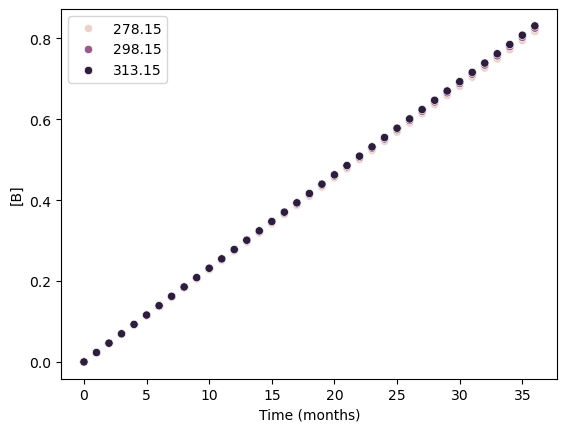

In [112]:
preds = batch_B_single(new_params, df, 0)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

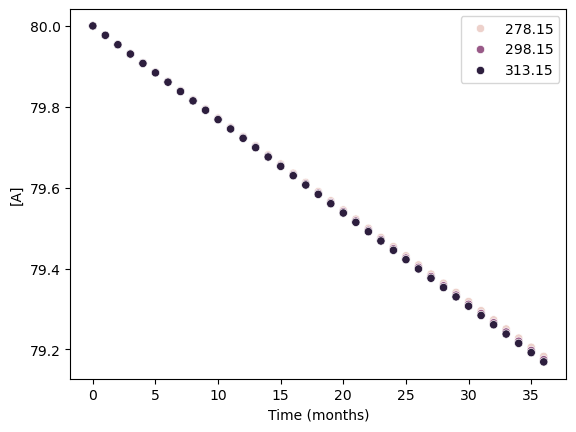

In [110]:
preds = batch_A_single(new_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[A]")
plt.legend()
plt.show()

### using the supporting material's parameters

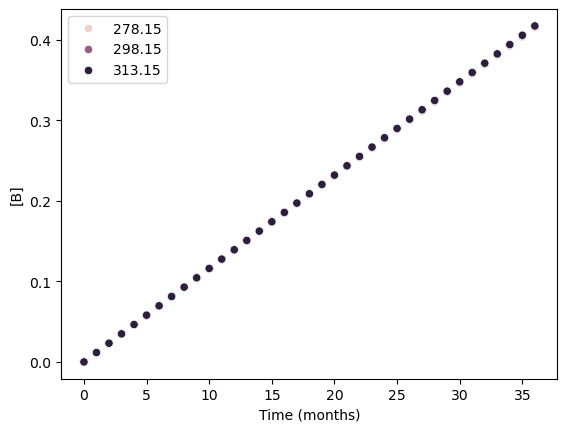

In [111]:
preds = batch_B_single(single_params, df, 0)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

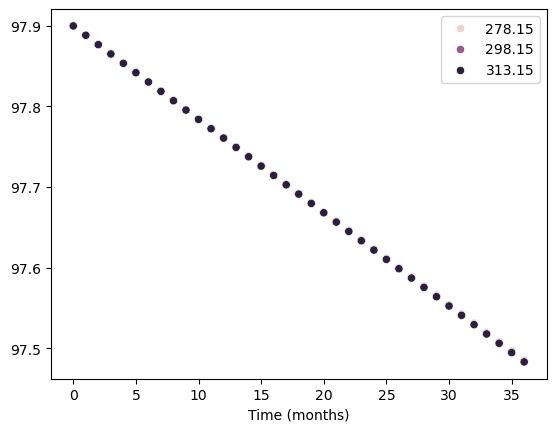

In [84]:
preds = batch_A_single(single_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])

plt.legend()
plt.show()

Looking at the parameters used on the purity acquired from NR CE-SDS, it seems that the data generated by GPT is somewhat imprecise as when we test the parameters, we acquire similar result just with the difference being $[A]_0$ and activation energy being higher when we try to fit the model with the data from GPT.

### real data

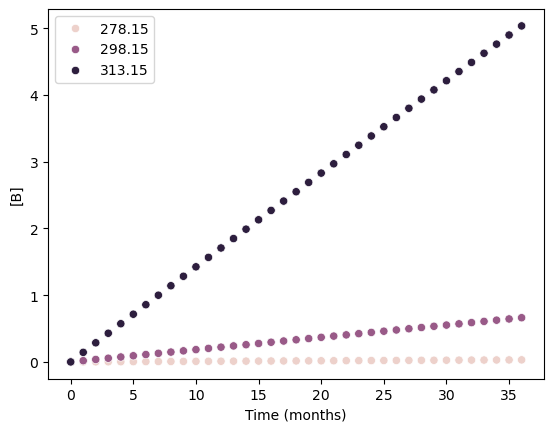

In [113]:
sns.scatterplot(x = df['Time (months)'], y = df['[B]'], hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

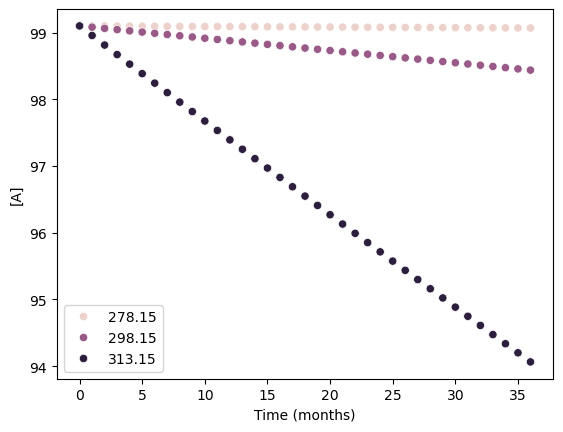

In [114]:
sns.scatterplot(x = df['Time (months)'], y = df['[A] Monomer (single)'], hue = df['Temp (K)'])
plt.ylabel("[A]")
plt.legend()
plt.show()

## Single N-th Order Reaction

In [97]:
lower_bounds_single_n = [80, 0, -np.inf, -np.inf]
upper_bounds_single_n = [100, np.inf, np.inf, np.inf]

def residuals_B_n_single(params, combined_input_data, y_observed):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_n_single(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_observed - y_predicted
    
def batch_B_n_single(params, combined_input_data):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_n_single(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_predicted

def batch_A_n_single(params, combined_input_data):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([A_single(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_predicted

In [122]:
initial_guess_n_single = np.array([100, (0.0005) , 120, 0])

In [123]:
result_B_n = least_squares(
    residuals_B_n_single,
    initial_guess_n_single,
    args=(df_train, df_train['[B]'] ), # taking assumption that [B]_0 is 0
    bounds=(lower_bounds_single_n, upper_bounds_single_n),
    method='dogbox'
)

In [124]:
new_params_n = result_B_n.x
new_params_n

array([9.99952734e+01, 1.61000584e-07, 1.81647412e+02, 2.40628678e+00])

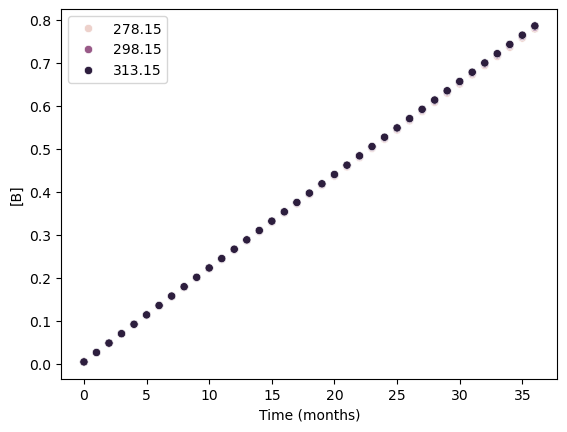

In [125]:
preds = batch_B_n_single(new_params_n, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

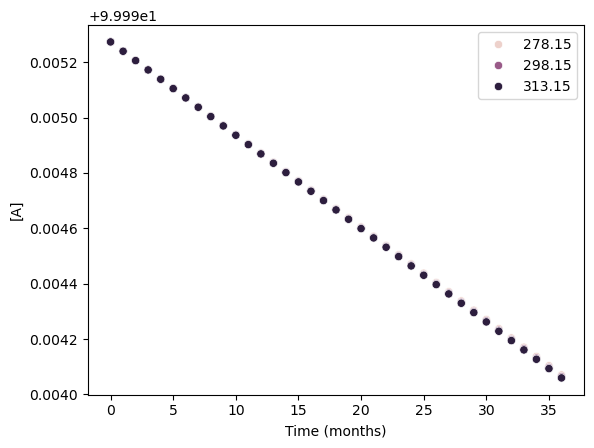

In [126]:
preds = batch_A_n_single(new_params_n, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[A]")
plt.legend()
plt.show()

### using supported material's parameter (Monomer)

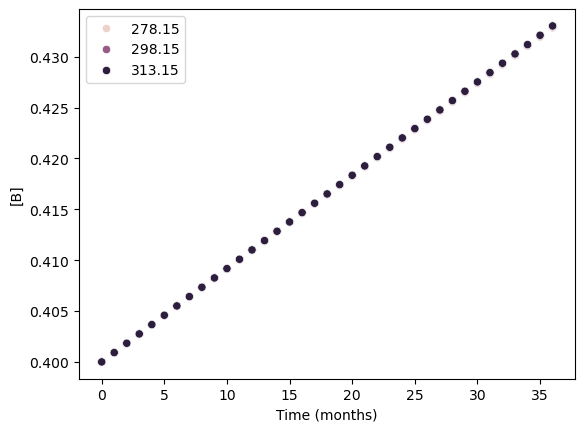

In [127]:
preds = batch_B_n_single(single_n_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

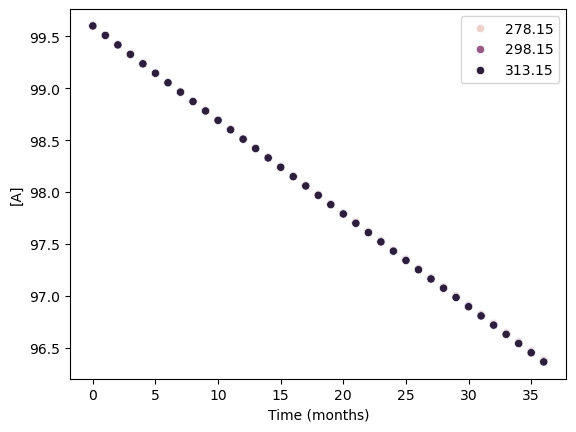

In [128]:
preds = batch_A_n_single(single_n_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[A]")
plt.legend()
plt.show()

The values of the parameters in the n-th order reaction are closer to the supporting material's parameters. This would suggest that I need better data to fit the model.